# Import Python Library and Algorithms

In [1]:
import numpy as np 
import pandas as pd 
import sys
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import string
from nltk.util import ngrams
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb


In [8]:
RANDOM_SEED = 42 
VAL_SIZE   = 0.2 # train = 0.8
DIR = 'for_training/data_for_preproc/'

# Import Data

In [9]:
train1 = pd.read_csv(DIR+'all_auto_ru_09_09_2020.csv', low_memory=False) 
train2 = pd.read_csv(DIR+'all_auto_ru_14_11_2020.csv', low_memory=False)
train3 = pd.read_csv(DIR+'finalfinal.csv') #new parse data from auto.ru

In [10]:
test = pd.read_csv(DIR+'test.csv')
sample_submission = pd.read_csv(DIR+'sample_submission.csv')

## Prepreprocessing

In [7]:
train1.info(), train2.info(), train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

(None, None, None)

**Concatenation Train data**

In [11]:
train3 = train3.drop('Unnamed: 0', axis=1)
train = pd.concat([train1, train2,train3])

In [10]:
train

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,equipment_dict,image,model_info,model_name,priceCurrency,sell_id,super_gen,vendor,price_EUR,price_USD
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991.0,SEDAN MECHANICAL 2.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986.0,SEDAN MECHANICAL 1.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989.0,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989.0,SEDAN MECHANICAL 1.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991.0,SEDAN MECHANICAL 2.0,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35266,седан,VOLVO,синий,бензин,2000.0,NaN,4.0,2003.0,NaN,автоматическая,...,NaN,NaN,NaN,S60,NaN,NaN,NaN,NaN,NaN,NaN
35267,универсал 5 дв.,VOLVO,чёрный,бензин,1995.0,NaN,5.0,1998.0,NaN,механическая,...,NaN,NaN,NaN,V40,NaN,NaN,NaN,NaN,NaN,NaN
35268,седан,VOLVO,серебристый,бензин,1983.0,NaN,4.0,1985.0,NaN,механическая,...,NaN,NaN,NaN,740,NaN,NaN,NaN,NaN,NaN,NaN
35269,седан,VOLVO,чёрный,бензин,1999.0,NaN,4.0,2001.0,NaN,механическая,...,NaN,NaN,NaN,S40,NaN,NaN,NaN,NaN,NaN,NaN


**Drop duplicates and cleaning train dataset**

In [12]:
train = train.drop_duplicates()

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197686 entries, 0 to 35270
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              197682 non-null  object 
 1   brand                 197686 non-null  object 
 2   color                 197685 non-null  object 
 3   fuelType              197685 non-null  object 
 4   modelDate             197682 non-null  float64
 5   name                  163204 non-null  object 
 6   numberOfDoors         197682 non-null  float64
 7   productionDate        197685 non-null  float64
 8   vehicleConfiguration  163204 non-null  object 
 9   vehicleTransmission   197682 non-null  object 
 10  engineDisplacement    197684 non-null  object 
 11  enginePower           197682 non-null  object 
 12  description           157351 non-null  object 
 13  mileage               197682 non-null  float64
 14  Комплектация          87264 non-null   object 
 15  П

In [13]:
train.isna().sum()

bodyType                     4
brand                        0
color                        1
fuelType                     1
modelDate                    4
name                     34482
numberOfDoors                4
productionDate               1
vehicleConfiguration     34482
vehicleTransmission          4
engineDisplacement           2
enginePower                  4
description              40335
mileage                      4
Комплектация            110422
Привод                       7
Руль                         4
Состояние               121743
Владельцы                27716
ПТС                        812
Таможня                  34479
Владение                148812
price                     1018
start_date               34479
hidden                  197686
model                   110422
complectation_dict      121743
equipment_dict          121743
image                   121743
model_info              121743
model_name               87267
priceCurrency           122039
sell_id 

**У признака Price есть пропущенные значения. Сразу удаляем их и почистим строки**

In [14]:
train.dropna(subset=['price', 'Привод', 'Руль'], inplace=True)

In [15]:
test.head(3).T

,0,1,2
bodyType,лифтбек,лифтбек,лифтбек
brand,SKODA,SKODA,SKODA
car_url,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/octavia/1...,https://auto.ru/cars/used/sale/skoda/superb/11...
color,синий,чёрный,серый
complectation_dict,NaN,NaN,"{""id"":""20026336"",""name"":""Ambition"",""available_..."
description,"Все автомобили, представленные в продаже, прох...",ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,"Все автомобили, представленные в продаже, прох..."
engineDisplacement,1.2 LTR,1.6 LTR,1.8 LTR
enginePower,105 N12,110 N12,152 N12
equipment_dict,"{""engine-proof"":true,""tinted-glass"":true,""airb...","{""cruise-control"":true,""asr"":true,""esp"":true,""...","{""cruise-control"":true,""tinted-glass"":true,""es..."
fuelType,бензин,бензин,бензин


In [16]:
test.info(), test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

(None,
 bodyType                    0
 brand                       0
 car_url                     0
 color                       0
 complectation_dict      28268
 description                 0
 engineDisplacement          0
 enginePower                 0
 equipment_dict           9996
 fuelType                    0
 image                       0
 mileage                     0
 modelDate                   0
 model_info                  0
 model_name                  0
 name                        0
 numberOfDoors               0
 parsing_unixtime            0
 priceCurrency               0
 productionDate              0
 sell_id                     0
 super_gen                   0
 vehicleConfiguration        0
 vehicleTransmission         0
 vendor                      0
 Владельцы                   0
 Владение                22691
 ПТС                         1
 Привод                      0
 Руль                        0
 Состояние                   0
 Таможня                     0
 

Тестовый датасет состоит из 32 признака и 34686 наблюдений.Из них dtypes: int64(6), object(26).А так же test имеет пропущенные данные.

In [15]:
categorical_feature = ['brand','color','fuelType','vehicleTransmission','vendor', 'bodyType']

In [17]:
train[categorical_feature].nunique()

brand                   36
color                   32
fuelType                 5
vehicleTransmission      8
vendor                   6
bodyType               199
dtype: int64

# EDA + Data preprocessing

#### **Создадим копии train и test . И будем работать с ними **

In [18]:
traincc = train.copy()
testcc = test.copy()

In [19]:
def preprocessing_train(df_input):
    
    
    df_output = df_input.copy()
    
    df_output.drop(['Состояние', 'Таможня', 'priceCurrency'], axis=1, inplace=True) #  все машины растаможены и в хорошем состояние
    
    
    
    # Feature Engineering 
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(re.findall('(\d+)', str(x))[0]))
    
    # color
    colors = {'040001': 'чёрный','FAFBFB': 'белый','97948F': 'серый','CACECB': 'серебристый','0000CC': 'синий',
              'EE1D19': 'красный','200204': 'бордовый','007F00': 'зелёный','C49648': 'коричневый','22A0F8': 'голубой',
              'DEA522': 'золотистый','FFD600': 'жёлтый','660099': 'пурпурный','4A2197': 'фиолетовый','FF8649': 'бежевый',
              'FFC0CB': 'розовый'}
    df_output['color'] = df_output['color'].replace(colors).apply(lambda x: x.lower())
    
    
    # vehicleTransmission
    
    vehicle = {'AUTOMATIC':'автоматическая','MECHANICAL':'механическая',
               'ROBOT':'роботизированная','VARIATOR':'вариатор'}
    df_output['vehicleTransmission'] = df_output['vehicleTransmission'].replace(vehicle)
    
    # ПТС
    df_output['ПТС'] = df_output['ПТС'].map({'ORIGINAL':'Оригинал','DUPLICATE':'Дубликат'})
    df_output['ПТС'] = df_output['ПТС'].fillna('Оригинал') # Заменяем пустых на более встречающийся
    
    # В train есть пустые значение,заменим их как неизвестные.
    
    df_output['vendor'] = df_output['vendor'].fillna('V_UNKNOWN') # Заменяем пустых на V_UNKNOWN
    
    
    # description
    
    df_output['description'] = df_output['description'].fillna('[]') 
    
    df_output['description_word'] = df_output['description'].apply(lambda x: [str(i).lower() for i in x.split()])
    
    df_output['leather']= df_output['description_word'].apply(lambda x: 
                                                1 if ('темный' and 'салон') in x else 0)
    df_output['carter']= df_output['description_word'].apply(lambda x: 
                                                1 if ('защита' and 'картера') in x else 0)
    df_output['ABS']= df_output['description_word'].apply(lambda x: 
                                                1 if ('антиблокировочная' and 'система') in x else 0)
    df_output['airbags']= df_output['description_word'].apply(lambda x: 
                                                1 if ('подушки' and 'безопасности') in x else 0)
    df_output['immob']= df_output['description_word'].apply(lambda x: 
                                                1 if ('иммобилайзер') in x else 0)
    df_output['central_locking']= df_output['description_word'].apply(lambda x: 
                                                1 if ('центральный' and 'замок') in x else 0)
    df_output['on_board_computer']= df_output['description_word'].apply(lambda x: 
                                                1 if ('бортовой' and 'компьютер') in x else 0)
    df_output['cruise_control']= df_output['description_word'].apply(lambda x: 
                                                1 if ('круиз-контроль') in x else 0)
    df_output['climat_control']= df_output['description_word'].apply(lambda x: 
                                                1 if ('климат-контроль') in x else 0)
    df_output['multi_rudder']= df_output['description_word'].apply(lambda x: 
                                                1 if ('мультифункциональный' and 'руль') in x else 0)
    df_output['power_steering']= df_output['description_word'].apply(lambda x: 
                                                1 if ('гидроусилитель' or 'гидро' or 'усилитель' and 'руля') in x else 0)
    df_output['light_and_rain_sensors']= df_output['description_word'].apply(lambda x: 
                                                1 if ('датчики' and 'света' and 'дождя') in x else 0)
    df_output['сarbon_body_kits']= df_output['description_word'].apply(lambda x: 
                                                1 if ('карбоновые' and 'обвесы') in x else 0)
    df_output['rear_diffuser_rkp']= df_output['description_word'].apply(lambda x: 
                                                1 if ('задний' and 'диффузор') in x else 0)
    df_output['door_closers']= df_output['description_word'].apply(lambda x: 
                                                1 if ('доводчики' and 'дверей') in x else 0)
    df_output['rear_view_camera']= df_output['description_word'].apply(lambda x: 
                                                1 if ('камера' or 'видеокамера' and 'заднего' and 'вида') in x else 0)
    df_output['amg']= df_output['description_word'].apply(lambda x: 
                                                1 if ('amg') in x else 0)
    df_output['bi_xenon_headlights']= df_output['description_word'].apply(lambda x: 
                                                1 if ('биксеноновые' and 'фары') in x else 0)
    df_output['from_salon']= df_output['description_word'].apply(lambda x: 
                                                1 if ('рольф' or 'панавто' or 'дилер' or 'кредит' or 'ликвидация') in x else 0)
    df_output['alloy_wheels']= df_output['description_word'].apply(lambda x: 
                                                1 if ('легкосплавные' or 'колесные' or 'диски') in x else 0)
    df_output['parking_sensors']= df_output['description_word'].apply(lambda x: 
                                                1 if ('парктроник' or 'парктронник') in x else 0)
    df_output['dents']= df_output['description_word'].apply(lambda x: 
                                                1 if ('вмятины' or 'вмятина' or 'царапина' or 'царапины' or 'трещина') in x else 0)
    df_output['roof_with_panoramic_view']= df_output['description_word'].apply(lambda x: 
                                                1 if ('панорамная' and 'крыша') in x else 0)
    
    # ################### fix ############################################################## 
    df_output['productionDate'] = df_output['productionDate'].values.astype('int64')
    df_output['sell_id'] = df_output['sell_id'].values.astype('int64')
    df_output['modelDate'] = df_output['modelDate'].values.astype('int64')
    df_output['numberOfDoors'] = df_output['numberOfDoors'].values.astype('int64')
    df_output['mileage'] = df_output['mileage'].values.astype('int64')
    df_output['mileageNAN'] = df_output['mileage'].apply(lambda x: 1 if x == 0 else 0)
    
    return df_output

In [20]:
def preprocessing_test(df_input):
    
    
    df_output = df_input.copy()
    
    df_output.drop(['Состояние', 'Таможня', 'priceCurrency'], axis=1, inplace=True) #  все машины растаможены и в хорошем состояние
    
    
    
    # Feature Engineering 
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(re.findall('(\d+)', str(x))[0]))
    
    # description
    
    df_output['description'] = df_output['description'].fillna('[]') 
    
    df_output['description_word'] = df_output['description'].apply(lambda x: [str(i).lower() for i in x.split()])
    
    df_output['leather']= df_output['description_word'].apply(lambda x: 
                                                1 if ('темный' and 'салон') in x else 0)
    df_output['carter']= df_output['description_word'].apply(lambda x: 
                                                1 if ('защита' and 'картера') in x else 0)
    df_output['ABS']= df_output['description_word'].apply(lambda x: 
                                                1 if ('антиблокировочная' and 'система') in x else 0)
    df_output['airbags']= df_output['description_word'].apply(lambda x: 
                                                1 if ('подушки' and 'безопасности') in x else 0)
    df_output['immob']= df_output['description_word'].apply(lambda x: 
                                                1 if ('иммобилайзер') in x else 0)
    df_output['central_locking']= df_output['description_word'].apply(lambda x: 
                                                1 if ('центральный' and 'замок') in x else 0)
    df_output['on_board_computer']= df_output['description_word'].apply(lambda x: 
                                                1 if ('бортовой' and 'компьютер') in x else 0)
    df_output['cruise_control']= df_output['description_word'].apply(lambda x: 
                                                1 if ('круиз-контроль') in x else 0)
    df_output['climat_control']= df_output['description_word'].apply(lambda x: 
                                                1 if ('климат-контроль') in x else 0)
    df_output['multi_rudder']= df_output['description_word'].apply(lambda x: 
                                                1 if ('мультифункциональный' and 'руль') in x else 0)
    df_output['power_steering']= df_output['description_word'].apply(lambda x: 
                                                1 if ('гидроусилитель' or 'гидро' or 'усилитель' and 'руля') in x else 0)
    df_output['light_and_rain_sensors']= df_output['description_word'].apply(lambda x: 
                                                1 if ('датчики' and 'света' and 'дождя') in x else 0)
    df_output['сarbon_body_kits']= df_output['description_word'].apply(lambda x: 
                                                1 if ('карбоновые' and 'обвесы') in x else 0)
    df_output['rear_diffuser_rkp']= df_output['description_word'].apply(lambda x: 
                                                1 if ('задний' and 'диффузор') in x else 0)
    df_output['door_closers']= df_output['description_word'].apply(lambda x: 
                                                1 if ('доводчики' and 'дверей') in x else 0)
    df_output['rear_view_camera']= df_output['description_word'].apply(lambda x: 
                                                1 if ('камера' or 'видеокамера' and 'заднего' and 'вида') in x else 0)
    df_output['amg']= df_output['description_word'].apply(lambda x: 
                                                1 if ('amg') in x else 0)
    df_output['bi_xenon_headlights']= df_output['description_word'].apply(lambda x: 
                                                1 if ('биксеноновые' and 'фары') in x else 0)
    df_output['from_salon']= df_output['description_word'].apply(lambda x: 
                                                1 if ('рольф' or 'панавто' or 'дилер' or 'кредит' or 'ликвидация') in x else 0)
    df_output['alloy_wheels']= df_output['description_word'].apply(lambda x: 
                                                1 if ('легкосплавные' or 'колесные' or 'диски') in x else 0)
    df_output['parking_sensors']= df_output['description_word'].apply(lambda x: 
                                                1 if ('парктроник' or 'парктронник') in x else 0)
    df_output['dents']= df_output['description_word'].apply(lambda x: 
                                                1 if ('вмятины' or 'вмятина' or 'царапина' or 'царапины' or 'трещина') in x else 0)
    df_output['roof_with_panoramic_view']= df_output['description_word'].apply(lambda x: 
                                                1 if ('панорамная' and 'крыша') in x else 0)
    
    return df_output

In [21]:
traincc = preprocessing_train(traincc)
testcc = preprocessing_test(testcc)


In [23]:
traincc.info(), testcc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196665 entries, 0 to 35270
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bodyType                  196665 non-null  object 
 1   brand                     196665 non-null  object 
 2   color                     196665 non-null  object 
 3   fuelType                  196665 non-null  object 
 4   modelDate                 196665 non-null  int64  
 5   name                      162498 non-null  object 
 6   numberOfDoors             196665 non-null  int64  
 7   productionDate            196665 non-null  int64  
 8   vehicleConfiguration      162498 non-null  object 
 9   vehicleTransmission       196665 non-null  object 
 10  engineDisplacement        196665 non-null  object 
 11  enginePower               196665 non-null  int64  
 12  description               196665 non-null  object 
 13  mileage                   196665 non-null  in

(None, None)

**Работаем с пустыми значениями**

In [24]:
traincc.isna().sum() , testcc.isna().sum()

(bodyType                         0
 brand                            0
 color                            0
 fuelType                         0
 modelDate                        0
 name                         34167
 numberOfDoors                    0
 productionDate                   0
 vehicleConfiguration         34167
 vehicleTransmission              0
 engineDisplacement               0
 enginePower                      0
 description                      0
 mileage                          0
 Комплектация                109812
 Привод                           0
 Руль                             0
 Владельцы                    27692
 ПТС                              0
 Владение                    148074
 price                            0
 start_date                   34167
 hidden                      196665
 model                       109812
 complectation_dict          121020
 equipment_dict              121020
 image                       121020
 model_info                 

In [22]:
testcc['ПТС'] = testcc['ПТС'].fillna('Оригинал')

Compare bodytype between train and test

In [26]:
testcc['bodyType'].value_counts()

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап полуторная кабина        5
пикап одинарная кабина         5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [23]:
traincc['bodyType'] = traincc['bodyType'].apply(lambda x: str(x).lower())

In [24]:
#Преобразуем bodyType
def proc_bodyType(df_input):
    df_output = df_input.copy()
    df_output['bodyType'] = df_output['bodyType'].apply(lambda x: str(x))
    def bodyType(row):
        for body_type in ['седан', 'внедорожник 5 дв.', 'лифтбек','хэтчбек 5 дв.', 
                      'универсал 5 дв.','минивэн','купе','компактвэн','хэтчбек 3 дв.','пикап двойная кабина',
                         'внедорожник 3 дв.','родстер','фургон','кабриолет','седан-хардтоп','микровэн',
                         'седан 2 дв.','лимузин','пикап полуторная кабина','пикап одинарная кабина',
                         'внедорожник открытый','тарга','фастбек']:
            if row.lower().startswith(body_type):
                return body_type
    df_output['bodyType'] = df_output['bodyType'].apply(bodyType)
    df_output['bodyType'] = df_output['bodyType'].apply(lambda x: 'купе' if x == 'купе-хардтоп' else x)
    
    return df_output

In [25]:
traincc = proc_bodyType(traincc)

In [26]:
traincc.bodyType.value_counts()

внедорожник 5 дв.          75458
седан                      69521
хэтчбек 5 дв.              17735
лифтбек                     7843
универсал 5 дв.             7482
минивэн                     4814
компактвэн                  3852
хэтчбек 3 дв.               3539
купе                        3479
пикап двойная кабина        1040
внедорожник 3 дв.            810
кабриолет                    400
родстер                      277
фургон                       224
микровэн                      44
внедорожник открытый          41
пикап полуторная кабина       40
пикап одинарная кабина        27
тарга                         12
лимузин                       12
фастбек                        5
Name: bodyType, dtype: int64

In [31]:
traincc.bodyType.isna().sum(), testcc.bodyType.isna().sum()

(10, 0)

In [27]:
traincc['bodyType'] = traincc['bodyType'].fillna('other')

In [33]:
traincc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196665 entries, 0 to 35270
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bodyType                  196665 non-null  object 
 1   brand                     196665 non-null  object 
 2   color                     196665 non-null  object 
 3   fuelType                  196665 non-null  object 
 4   modelDate                 196665 non-null  int64  
 5   name                      162498 non-null  object 
 6   numberOfDoors             196665 non-null  int64  
 7   productionDate            196665 non-null  int64  
 8   vehicleConfiguration      162498 non-null  object 
 9   vehicleTransmission       196665 non-null  object 
 10  engineDisplacement        196665 non-null  object 
 11  enginePower               196665 non-null  int64  
 12  description               196665 non-null  object 
 13  mileage                   196665 non-null  in

**У нас стоимости машины разбросаны, поэтому построим зависимость от логарифма цены**

In [28]:
traincc['log_price'] = np.log(traincc.price)

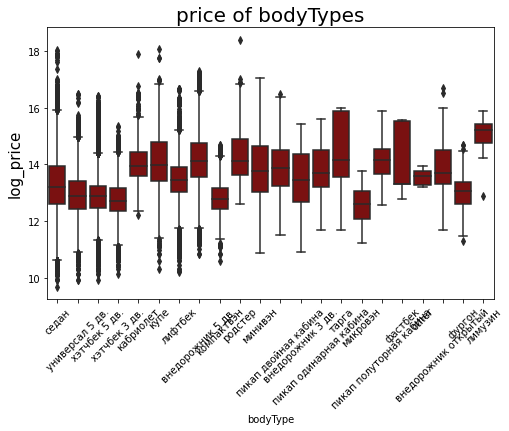

In [35]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='bodyType', 
                  data=traincc, color='darkred')
g1.set_title("price of bodyTypes", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [29]:
traincc = traincc.assign(bT_length = traincc['bodyType'].apply(len))
testcc = testcc.assign(bT_length = testcc['bodyType'].apply(len))

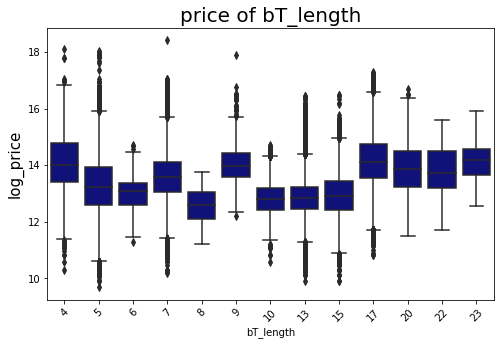

In [37]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='bT_length', 
                  data=traincc, color='darkblue')
g1.set_title("price of bT_length", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

### **Brand**

In [39]:
len(traincc.brand.value_counts()),len(testcc.brand.value_counts())

(36, 12)

In [31]:
brand = testcc.brand.value_counts()
brand

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

#### *Сравним с тестом оставим по брендам с теста , а остальных объединим как otherBrand*

In [32]:
traincc['brand'] = traincc['brand'].apply(lambda x: x if x in brand else 'otherBrand')

In [42]:
traincc['brand'].value_counts()

otherBrand    72803
BMW           25008
MERCEDES      19738
VOLKSWAGEN    14890
NISSAN        12591
TOYOTA         9774
AUDI           9433
MITSUBISHI     7915
SKODA          7137
VOLVO          6696
LEXUS          4786
INFINITI       3440
HONDA          2454
Name: brand, dtype: int64

In [43]:
traincc.groupby('brand').price.describe()

,count,mean,std,min,25%,50%,75%,max
brand,,,,,,,,
AUDI,9433.0,1.522357e+06,1.561080e+06,25000.0,490000.0,999000.0,1949000.00,14898500.0
BMW,25008.0,2.089682e+06,2.117583e+06,45000.0,680000.0,1349000.0,2915250.00,16290000.0
HONDA,2454.0,6.525764e+05,5.241758e+05,40000.0,340000.0,500000.0,840000.00,5697338.0
INFINITI,3440.0,1.478583e+06,9.872982e+05,105000.0,760000.0,1268500.0,1800000.00,6849262.0
LEXUS,4786.0,2.169833e+06,1.574467e+06,65000.0,950000.0,1799000.0,2980000.00,17450000.0
MERCEDES,19738.0,3.993114e+06,4.282514e+06,40000.0,1050000.0,2898900.0,5344400.00,72000000.0
MITSUBISHI,7915.0,9.034161e+05,7.729267e+05,38000.0,280000.0,599999.0,1455500.00,3572805.0
NISSAN,12591.0,8.762641e+05,6.513000e+05,25000.0,400000.0,685000.0,1200000.00,7900000.0
SKODA,7137.0,7.478957e+05,5.043362e+05,20000.0,439000.0,615000.0,899000.00,3180000.0


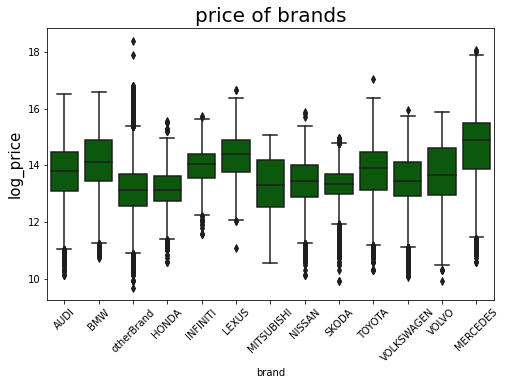

In [44]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='brand', 
                  data=traincc, color='darkgreen')
g1.set_title("price of brands", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

**Как мы видим  BMW ,LEXUS и Mercedes дороже **

In [33]:
#Тест искуственной фичи,длины названия марки
traincc = traincc.assign(brand_length = traincc['brand'].apply(len))
testcc = testcc.assign(brand_length = testcc['brand'].apply(len))

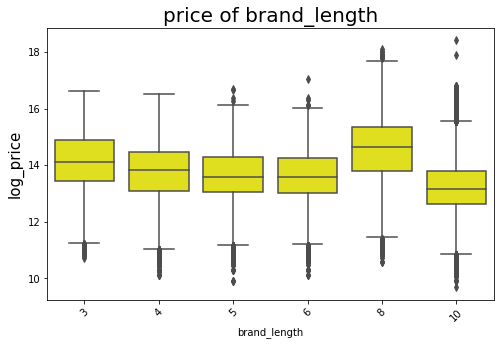

In [46]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='brand_length', 
                  data=traincc, color='yellow')
g1.set_title("price of brand_length", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [47]:
len(testcc.model_name.value_counts()), len(traincc.model_name.value_counts())

(544, 1073)

In [48]:
testcc.complectation_dict.isna().sum(),traincc.complectation_dict.isna().sum()

(28268, 121020)

In [49]:
testcc.equipment_dict.isna().sum(),traincc.equipment_dict.isna().sum()

(9996, 121020)

complectation_dict и equipment_dict удаляем ,много пропусков

In [50]:
traincc.isna().sum().value_counts(), testcc.isna().sum().value_counts()

(0         46
 121020     7
 34167      3
 109812     2
 196665     1
 27692      1
 148074     1
 86856      1
 dtype: int64,
 0        52
 28268     1
 22691     1
 9996      1
 dtype: int64)

У нас еще есть пропуски по train-> name , vehicleConfiguration,vehicleTransmission,Комплектация,Владельцы,Владение ,hidden , model.......

In [51]:
traincc.isna().sum().head(30),traincc.isna().sum().tail(33)

(bodyType                     0
 brand                        0
 color                        0
 fuelType                     0
 modelDate                    0
 name                     34167
 numberOfDoors                0
 productionDate               0
 vehicleConfiguration     34167
 vehicleTransmission          0
 engineDisplacement           0
 enginePower                  0
 description                  0
 mileage                      0
 Комплектация            109812
 Привод                       0
 Руль                         0
 Владельцы                27692
 ПТС                          0
 Владение                148074
 price                        0
 start_date               34167
 hidden                  196665
 model                   109812
 complectation_dict      121020
 equipment_dict          121020
 image                   121020
 model_info              121020
 model_name               86856
 sell_id                      0
 dtype: int64,
 sell_id                 

In [34]:
traincc['model_name'] = traincc['model_name'].fillna(traincc['model'])

In [35]:
traincc.model_info[4],testcc.model_info[4]

(4                                                  NaN
 4    {'code': '100', 'name': '100', 'ru_name': '100...
 4                                                  NaN
 Name: model_info, dtype: object,
 '{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}')

In [55]:
testcc.equipment_dict.value_counts().head(5)

{"leather":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           108
{"gbo":true}                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [56]:
testcc.name[:30]

0          1.2 AMT (105 л.с.)
1           1.6 MT (110 л.с.)
2      DSG 1.8 AMT (152 л.с.)
3           1.6 AT (110 л.с.)
4           1.8 AT (152 л.с.)
5          2.0 AMT (200 л.с.)
6      1.8 AMT (152 л.с.) 4WD
7           1.6 MT (102 л.с.)
8       1.4 MT (150 л.с.) 4WD
9       1.8 MT (152 л.с.) 4WD
10           1.6 MT (90 л.с.)
11         1.4 AMT (150 л.с.)
12         1.8 AMT (180 л.с.)
13     1.4 AMT (150 л.с.) 4WD
14          1.6 AT (102 л.с.)
15         1.4 AMT (150 л.с.)
16         1.8 AMT (180 л.с.)
17         1.4 AMT (150 л.с.)
18          1.6 AT (110 л.с.)
19          1.6 AT (110 л.с.)
20     1.4 AMT (150 л.с.) 4WD
21    2.0d AMT (150 л.с.) 4WD
22          1.6 AT (110 л.с.)
23          1.8 AT (152 л.с.)
24         2.0 AMT (220 л.с.)
25          1.2 MT (105 л.с.)
26     DSG 1.8 AMT (152 л.с.)
27         1.8 AMT (180 л.с.)
28          1.4 MT (122 л.с.)
29          1.6 AT (105 л.с.)
Name: name, dtype: object

equipment_dict,name,model_info можем удалить ,Информация продублированы

### **enginePower**

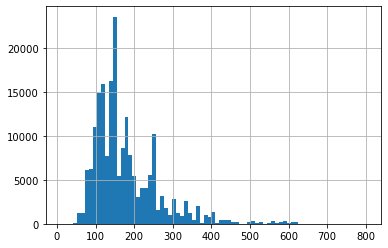

In [58]:
traincc['enginePower'].hist(bins=77)

In [58]:
traincc.enginePower.describe()

count    196665.000000
mean        178.837500
std          86.239581
min          11.000000
25%         120.000000
50%         150.000000
75%         218.000000
max         800.000000
Name: enginePower, dtype: float64

In [36]:
traincc['log_power'] = np.log(traincc.enginePower)

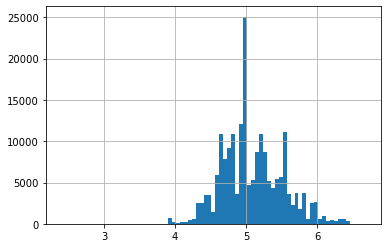

In [60]:
traincc['log_power'].hist(bins=77)

#### Логарифмирование enginePower метрику сильно  не улучшило.Попробуем ввести признак соответствующий налогу в зависимости от enginePower.

### New feature - Nalog

In [37]:
bins = [10, 35, 100, 125, 150, 175, 200, 225, 250, 801]
numbers = ['5000','12','25','35', '45', '50', '65', '75', '150']

In [38]:
traincc['Nalog_base']=pd.cut(traincc['enginePower'],bins,labels=numbers)
testcc['Nalog_base']=pd.cut(testcc['enginePower'],bins,labels=numbers)


In [39]:
traincc['Nalog_base'] = traincc['Nalog_base'].values.astype('int64')
testcc['Nalog_base'] = testcc['Nalog_base'].values.astype('int64')

In [64]:
traincc['Nalog_base']

0        45
1        12
2        35
3        12
4        25
         ..
35266    45
35267    45
35268    35
35269    25
35270    50
Name: Nalog_base, Length: 196665, dtype: int64

In [40]:
testcc['enginePower'] = testcc['enginePower'].astype(float)

In [66]:
testcc.enginePower.describe()

count    34686.000000
mean       188.194142
std         89.087035
min         30.000000
25%        125.000000
50%        169.000000
75%        233.000000
max        639.000000
Name: enginePower, dtype: float64

In [41]:
testcc['log_power'] = np.log(testcc.enginePower)

In [42]:
#Посчитаем стоимость налога в соответствии с мощностью двигателя
traincc['Nalog'] = traincc['enginePower'] * traincc['Nalog_base']
testcc['Nalog'] = testcc['enginePower'] * testcc['Nalog_base']

In [69]:
traincc['Nalog'] ,testcc['Nalog']

(0        7830
 1        1080
 2        4760
 3        1080
 4        2525
          ... 
 35266    7650
 35267    7200
 35268    4585
 35269    2725
 35270    9000
 Name: Nalog, Length: 196665, dtype: int64,
 0         2625.0
 1         2750.0
 2         6840.0
 3         2750.0
 4         6840.0
           ...   
 34681     4760.0
 34682     9500.0
 34683     7650.0
 34684     9200.0
 34685    17625.0
 Name: Nalog, Length: 34686, dtype: float64)

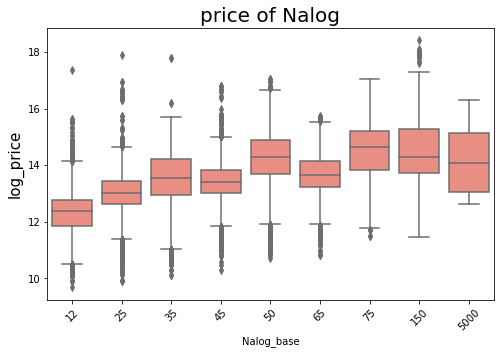

In [70]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Nalog_base', 
                  data=traincc, color='salmon')
g1.set_title("price of Nalog", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

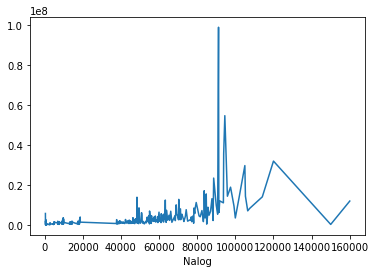

In [71]:
traincc.groupby('Nalog').price.mean().plot()

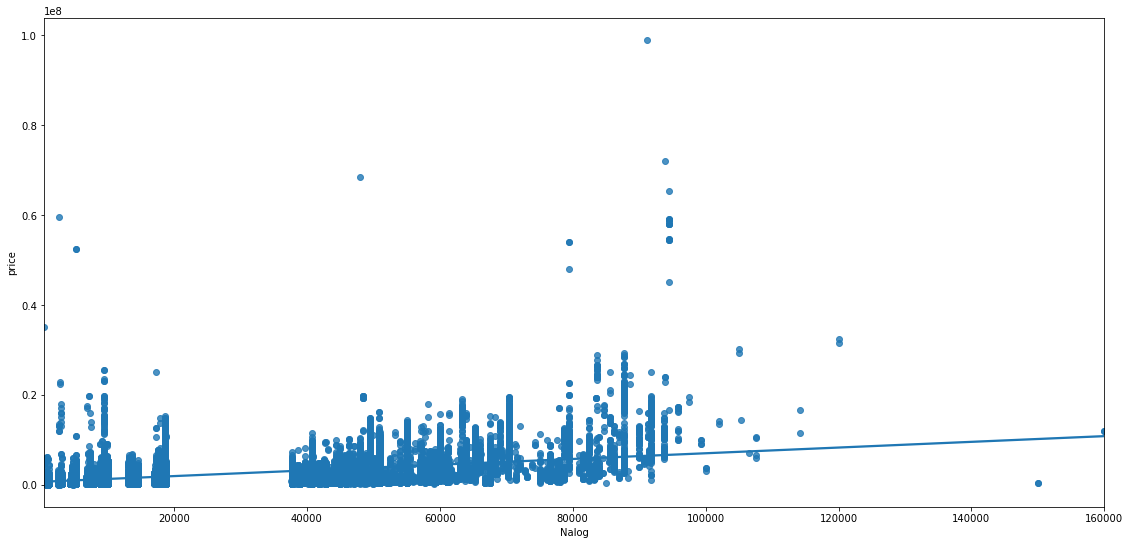

In [59]:
plt.figure(figsize=(19, 9))
#Как мы видим, есть определенная корреляция налога и цены на авто. Выбросы могут создавать раритетные авто или премиум класс
sns.regplot(traincc['Nalog'],y=traincc['price'])

### engineDisplacement

In [72]:
traincc.engineDisplacement.value_counts()

1.6        32135
2.0        27700
1.4        10290
1.8         9597
2.0 LTR     9052
           ...  
50             1
Base           1
PHEV           1
Prime          1
116            1
Name: engineDisplacement, Length: 592, dtype: int64

In [48]:
#Избавимся от излишних стрингов после значения объема двигателя
traincc['engineDisplacement'] = traincc['engineDisplacement'].apply(lambda x: x[:3])
testcc['engineDisplacement'] = testcc['engineDisplacement'].apply(lambda x: x[:3])

In [49]:
traincc['engineDisplacement'].value_counts().head(41)

2.0    43031
1.6    35843
3.0    14368
1.8    12109
1.4    11515
2.5    10527
2.4     8250
1.5     5433
3.5     4631
4.4     2036
1.3     1988
2.2     1987
2.3     1928
1.2     1885
1.7     1519
2.9     1514
200     1504
350     1436
2.7     1383
4.0     1225
2.8     1140
3.6     1136
3.2     1126
320     1092
4.5     1089
4.7      802
3.7      765
1.9      762
4.2      675
520      662
300      661
2.1      661
0.8      619
5.7      583
250      581
500      568
4.6      567
5.6      553
5.0      539
450      501
4.8      498
Name: engineDisplacement, dtype: int64

In [50]:
traincc[traincc['engineDisplacement'] == 'S4']

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,parking_sensors,dents,roof_with_panoramic_view,mileageNAN,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog
45,седан,AUDI,чёрный,бензин,1990,S4 2.2 AT (230 л.с.) 4WD,4,1992,SEDAN AUTOMATIC S4,автоматическая,...,0,0,0,0,12.301383,5,4,5.438079,75,17250
63640,седан,otherBrand,серебристый,бензин,2014,S4 2.0 CVT (300 л.с.) 4WD,4,2014,SEDAN VARIATOR S4,вариатор,...,0,0,0,0,14.187074,5,10,5.703782,150,45000


In [76]:
len(testcc[testcc['engineDisplacement'] == ' LT'])

55

In [77]:
traincc[traincc['engineDisplacement'] == ' LT']

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,parking_sensors,dents,roof_with_panoramic_view,mileageNAN,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog
15011,хэтчбек 5 дв.,BMW,серый,электро,2013,NaN,5,2017,NaN,автоматическая,...,0,0,0,0,14.403297,13,3,5.135798,45,7650
15013,хэтчбек 5 дв.,BMW,синий,электро,2017,NaN,5,2017,NaN,автоматическая,...,0,0,0,0,14.557448,13,3,5.214936,50,9200
15019,хэтчбек 5 дв.,BMW,серый,электро,2017,NaN,5,2018,NaN,автоматическая,...,0,0,0,0,14.483340,13,3,5.135798,45,7650
15022,хэтчбек 5 дв.,BMW,чёрный,электро,2013,NaN,5,2015,NaN,автоматическая,...,0,0,0,0,13.864301,13,3,5.135798,45,7650
15029,хэтчбек 5 дв.,BMW,белый,электро,2013,NaN,5,2016,NaN,автоматическая,...,0,0,0,0,13.955273,13,3,5.135798,45,7650
15031,хэтчбек 5 дв.,BMW,серый,электро,2013,NaN,5,2014,NaN,автоматическая,...,0,0,0,0,14.508658,13,3,5.135798,45,7650
15032,хэтчбек 5 дв.,BMW,чёрный,электро,2013,NaN,5,2014,NaN,автоматическая,...,0,0,0,0,14.247293,13,3,5.135798,45,7650
15033,хэтчбек 5 дв.,BMW,красный,электро,2013,NaN,5,2014,NaN,автоматическая,...,0,0,0,0,14.124465,13,3,5.135798,45,7650
15038,хэтчбек 5 дв.,BMW,чёрный,электро,2013,NaN,5,2015,NaN,автоматическая,...,0,0,0,0,13.955273,13,3,5.135798,45,7650
15041,хэтчбек 5 дв.,BMW,синий,электро,2017,NaN,5,2018,NaN,автоматическая,...,0,0,0,0,14.815775,13,3,5.214936,50,9200


In [78]:
traincc.groupby('engineDisplacement').enginePower.describe().head(20)

,count,mean,std,min,25%,50%,75%,max
engineDisplacement,,,,,,,,
LT,13.0,167.923077,16.735499,115.0,170.0,170.0,170.0,184.0
+,1.0,75.000000,NaN,75.0,75.0,75.0,75.0,75.0
0.6,8.0,173.500000,6.480741,170.0,170.0,170.0,173.5,184.0
0.7,166.0,75.843373,44.254356,45.0,52.0,58.0,64.0,184.0
0.8,619.0,51.767367,1.667557,38.0,52.0,52.0,52.0,52.0
1.0,384.0,64.705729,6.846651,42.0,60.0,67.0,68.0,125.0
1.1,144.0,65.090278,8.006914,30.0,64.0,66.0,68.0,101.0
1.2,1885.0,89.402653,16.469804,44.0,75.0,85.0,105.0,116.0
1.3,1988.0,107.733903,38.976902,40.0,82.0,88.0,150.0,255.0


In [52]:
traincc['engineDisplacement'] = traincc['engineDisplacement'].apply(lambda x: 1.6 if x == ' LT' else x)
testcc['engineDisplacement'] = testcc['engineDisplacement'].apply(lambda x: 1.6 if x == ' LT' else x)

In [53]:
traincc['engineDisplacement'].value_counts()[:41].keys()

Index(['2.0', '1.6', '3.0', '1.8', '1.4', '2.5', '2.4', '1.5', '3.5', '4.4',
       '1.3', '2.2', '2.3', '1.2', '1.7', '2.9', '200', '350', '2.7', '4.0',
       '2.8', '3.6', '3.2', '320', '4.5', '4.7', '3.7', '1.9', '4.2', '520',
       '300', '2.1', '0.8', '5.7', '250', '500', '4.6', '5.6', '5.0', '450',
       '4.8'],
      dtype='object')

In [54]:
brand_list = list(traincc['engineDisplacement'].value_counts()[:41].keys())
traincc['engineDisplacement'] = traincc['engineDisplacement'].apply(lambda x: x if x in brand_list else 1.8)

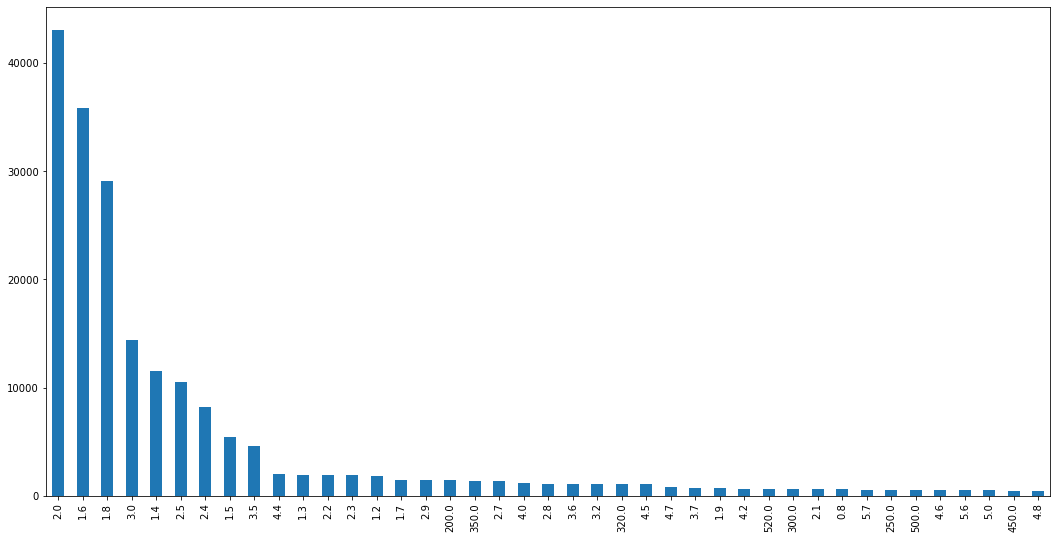

In [60]:
plt.figure(figsize=(18, 9))
traincc['engineDisplacement'] = traincc['engineDisplacement'].astype('float')
traincc['engineDisplacement'].value_counts().plot(kind='bar')

### Vehicle

In [83]:
traincc.vehicleTransmission.value_counts(),testcc.vehicleTransmission.value_counts()

(автоматическая      112906
 механическая         51102
 роботизированная     17613
 вариатор             15044
 Name: vehicleTransmission, dtype: int64,
 автоматическая      19596
 механическая         7209
 вариатор             3999
 роботизированная     3882
 Name: vehicleTransmission, dtype: int64)

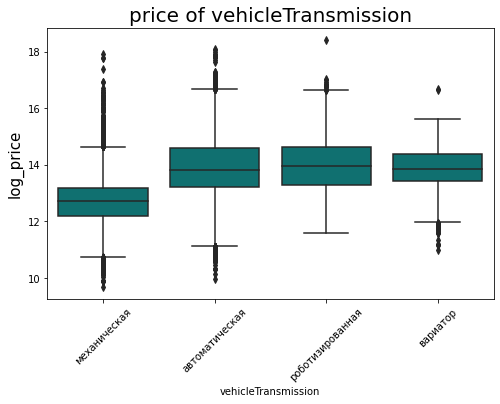

In [84]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='vehicleTransmission', 
                  data=traincc, color='teal')
g1.set_title("price of vehicleTransmission", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [85]:
traincc.vehicleConfiguration[67]

67    SEDAN MECHANICAL 2.6
67    SEDAN MECHANICAL 2.2
67                     NaN
Name: vehicleConfiguration, dtype: object

### Num of doors

In [86]:
testcc[testcc.numberOfDoors == 0] 

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,from_salon,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,bT_length,brand_length,Nalog_base,log_power,Nalog
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,NaN,бензин,...,0,0,0,0,0,9,8,5000,3.465736,160000.0


In [87]:
traincc[traincc.numberOfDoors == 0]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,parking_sensors,dents,roof_with_panoramic_view,mileageNAN,log_price,bT_length,brand_length,log_power,Nalog_base,Nalog
88065,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,...,0,0,0,0,16.300417,9,8,3.465736,5000,160000
76332,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,...,0,0,0,0,16.300417,9,8,3.465736,5000,160000


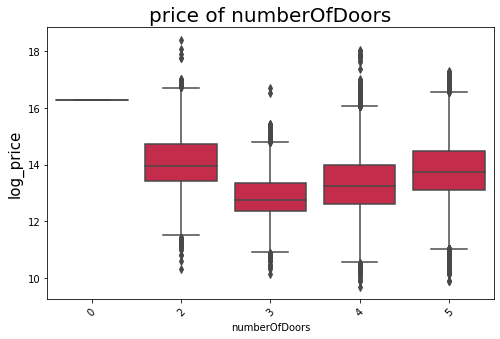

In [88]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='numberOfDoors', 
                  data=traincc, color='crimson')
g1.set_title("price of numberOfDoors", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

### Color

In [89]:
display(pd.DataFrame(traincc.color.value_counts()))

,color
чёрный,57176
белый,35008
серый,24004
серебристый,23214
синий,19901
красный,9942
бордовый,6582
зелёный,5500
коричневый,5094
голубой,2890


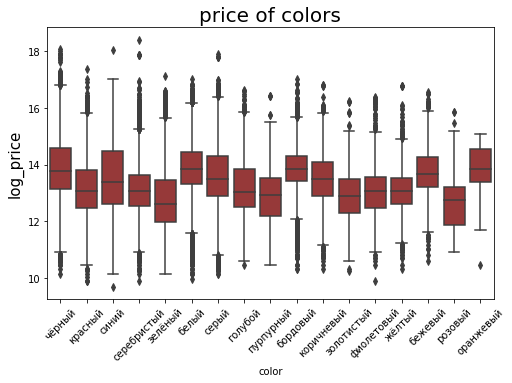

In [90]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='color', 
                  data=traincc, color='brown')
g1.set_title("price of colors", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Узнаем сколько год машину

In [61]:
traincc['years_old'] = 2021 - traincc['productionDate']
testcc['years_old'] = 2021 - testcc['productionDate']

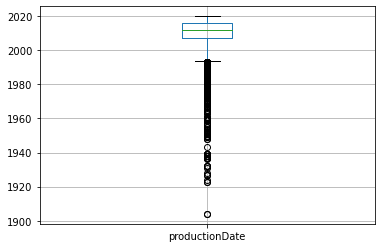

In [92]:
traincc.boxplot(column=['productionDate'])

In [93]:
traincc.years_old.value_counts().head(10)

1     27209
13    14484
9     14020
10    13014
8     12361
14    11248
7     10482
11     9440
4      7947
6      7874
Name: years_old, dtype: int64

In [94]:
traincc.years_old.describe(),testcc.years_old.describe()

(count    196665.000000
 mean         10.064129
 std           7.111146
 min           1.000000
 25%           5.000000
 50%           9.000000
 75%          14.000000
 max         117.000000
 Name: years_old, dtype: float64,
 count    34686.000000
 mean        11.735398
 std          7.047661
 min          1.000000
 25%          7.000000
 50%         10.000000
 75%         15.000000
 max        117.000000
 Name: years_old, dtype: float64)

#### *Разобьем возраст на интервалы*

In [62]:
bins = [-1, 3, 7, 14, 20, 35, 117]
numbers = ['3', '7','14','20','35', '117']

traincc['age_intervals']= pd.cut(traincc['years_old'],bins,labels=numbers)
testcc['age_intervals']= pd.cut(testcc['years_old'],bins,labels=numbers)

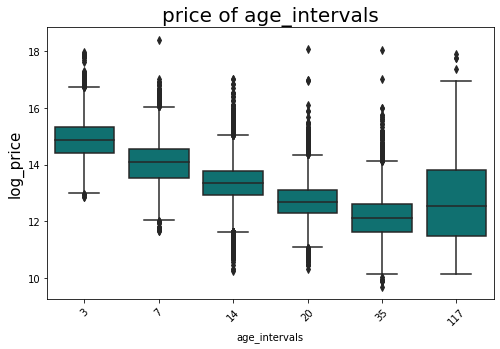

In [96]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='age_intervals', 
                  data=traincc, color='teal')
g1.set_title("price of age_intervals", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

### modelDate

In [97]:
traincc.modelDate.describe(),testcc.modelDate.describe()

(count    196665.000000
 mean       2008.702026
 std           7.515578
 min        1904.000000
 25%        2005.000000
 50%        2010.000000
 75%        2014.000000
 max        2020.000000
 Name: modelDate, dtype: float64,
 count    34686.000000
 mean      2007.074728
 std          7.415894
 min       1904.000000
 25%       2004.000000
 50%       2008.000000
 75%       2012.000000
 max       2020.000000
 Name: modelDate, dtype: float64)

In [98]:
traincc.modelDate.value_counts().head()

2006    12946
2010    12463
2009    11522
2017    10761
2018    10698
Name: modelDate, dtype: int64

Владельцы

In [99]:
traincc['Владельцы'].isna().sum(),testcc['Владельцы'].isna().sum(),

(27692, 0)

In [100]:
traincc.Владельцы.value_counts() ,testcc.Владельцы.value_counts()

(3.0            62962
 2.0            36779
 1.0            35068
 3 или более    16398
 1владелец       9226
 2владельца      8540
 Name: Владельцы, dtype: int64,
 3 или более    15957
 1 владелец      9459
 2 владельца     9270
 Name: Владельцы, dtype: int64)

In [63]:
testcc['Владельцы']= testcc['Владельцы'].astype('category')
traincc['Владельцы']= traincc['Владельцы'].astype('category')

traincc['Владельцы']= traincc['Владельцы'].apply(lambda x: int(re.findall('\d', str(x))[0]))
testcc['Владельцы']= testcc['Владельцы'].apply(lambda x: int(re.findall('\d', str(x))[0]))

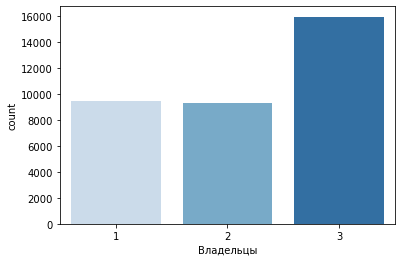

In [102]:
sns.countplot(x = "Владельцы", data = testcc, palette = "Blues")

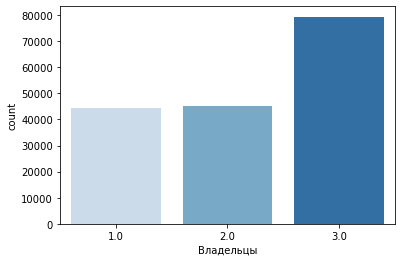

In [103]:
sns.countplot(x = "Владельцы", data = traincc, palette = "Blues")

In [64]:
traincc['Владельцы'] = traincc['Владельцы'].astype("category")

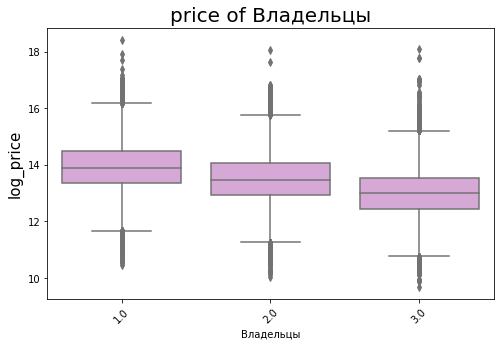

In [105]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='Владельцы', 
                  data=traincc, color='plum')
g1.set_title("price of Владельцы", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

#### Число владельца напрямую влияет на цену. Как мы видим если в машине  1 Владелец,то этот машина дороже чем остальные

### Владение

In [106]:
traincc.Владение.isna().sum(),testcc.Владение.isna().sum()

(148074, 22691)

In [107]:
traincc.groupby('Владельцы').Владение.describe()

,count,unique,top,freq
Владельцы,,,,
1.0,12659,265,"{'year': 2018, 'month': 12}",191
2.0,13509,261,"{'year': 2018, 'month': 11}",237
3.0,22423,262,"{'year': 2019, 'month': 8}",503


### РУЛЬ

In [108]:
testcc.Руль.value_counts(), traincc.Руль.value_counts()

(Левый     33287
 Правый     1399
 Name: Руль, dtype: int64,
 LEFT      159327
 Левый      34021
 RIGHT       3171
 Правый       146
 Name: Руль, dtype: int64)

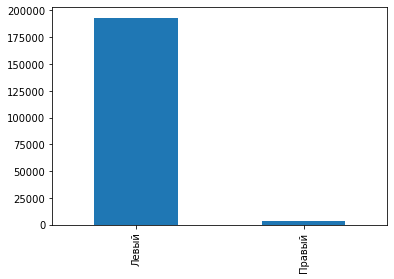

In [65]:
rule={'LEFT': 'Левый', 'RIGHT': 'Правый' }
traincc['Руль'] = traincc['Руль'].replace(rule)
traincc['Руль'].value_counts().plot.bar()

 ####   **Как правило ,видим что леворульки больше чем правый**

### **fuelType**

In [110]:
traincc.fuelType.value_counts(),testcc.fuelType.value_counts()

(бензин     162658
 дизель      32955
 гибрид        805
 электро       214
 газ            33
 Name: fuelType, dtype: int64,
 бензин     28601
 дизель      5800
 гибрид       223
 электро       55
 газ            7
 Name: fuelType, dtype: int64)

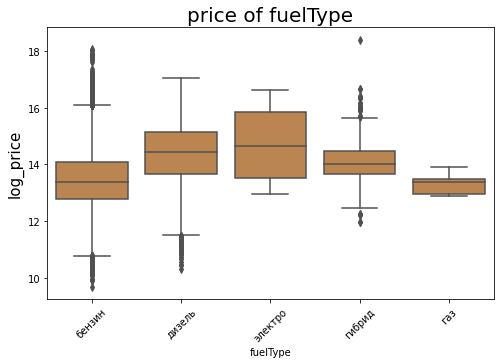

In [111]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='fuelType', 
                  data=traincc, color='peru')
g1.set_title("price of fuelType", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


plt.show()

In [112]:
testcc.super_gen[2]

'{"id":"20026323","nameplate":"DSG","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":152,"power_kvt":112,"human_name":"DSG 1.8 AMT (152 л.с.)","acceleration":8.7,"clearance_min":139,"fuel_rate":7.1,"clearance_max":158}'

### **vendor**

In [113]:
traincc.vendor.value_counts(),testcc.vendor.value_counts()

(V_UNKNOWN    121020
 EUROPEAN      40010
 JAPANESE      16513
 KOREAN         9666
 AMERICAN       7359
 RUSSIAN        1057
 CHINESE        1040
 Name: vendor, dtype: int64,
 EUROPEAN    20682
 JAPANESE    14004
 Name: vendor, dtype: int64)

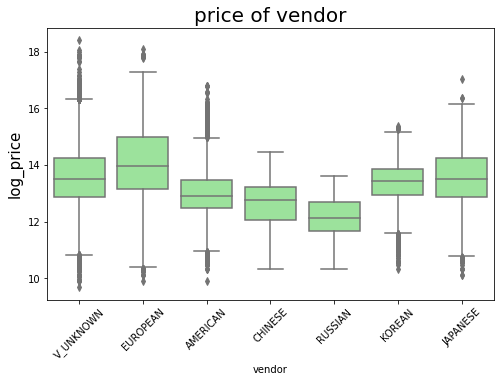

In [114]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='vendor', 
                  data=traincc, color='lightgreen')
g1.set_title("price of vendor", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)


plt.show()

### mileage

In [115]:
traincc.mileage.describe()

count     196665.000000
mean      135667.779264
std       103891.426898
min            0.000000
25%        56137.000000
50%       129000.000000
75%       196000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [116]:
traincc[traincc.mileage == 0].groupby('years_old').price.describe()

,count,mean,std,min,25%,50%,75%,max
years_old,,,,,,,,
1,26047.0,4.028237e+06,3.125717e+06,627000.0,1910500.0,3140000.0,4930000.0,65435792.0
2,1540.0,6.147286e+06,4.370824e+06,871900.0,2532000.0,4061500.0,9041330.0,20770330.0
3,101.0,1.418830e+07,1.947822e+07,899900.0,4725000.0,6570070.0,7850000.0,59087576.0
4,1.0,3.829900e+06,NaN,3829900.0,3829900.0,3829900.0,3829900.0,3829900.0


In [117]:
traincc.groupby('years_old').mileage.mean().head(10)

years_old
1        221.086442
2      18540.637895
3      47010.312286
4      69362.186863
5      87640.432554
6     100440.519812
7     114898.115150
8     126626.361621
9     136818.031384
10    147449.666282
Name: mileage, dtype: float64

#### Мы считали что в среднем за первый год машина проходит до 10 000 км, а после по  как минимум 20000 

In [66]:
traincc['mileageNAN'] = traincc.mileageNAN * (traincc.years_old * 20000 + 10000)

In [67]:
traincc.mileage = traincc.mileage + traincc.mileageNAN

In [120]:
traincc.mileage.describe()

count     196665.000000
mean      140069.019953
std        98596.005712
min            1.000000
25%        56666.000000
50%       129000.000000
75%       196000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [121]:
traincc.groupby('years_old').mileage.mean().head(10)

years_old
1      28939.892719
2      30780.345414
3      48018.008979
4      69373.511891
5      87640.432554
6     100440.519812
7     114898.115150
8     126626.361621
9     136818.031384
10    147449.666282
Name: mileage, dtype: float64

In [122]:
traincc[traincc.mileage == 1].productionDate

18051    2005
24788    2019
24789    2019
42002    2019
53666    1996
59535    2014
83747    2020
83820    2020
85056    2020
86843    2020
88166    2020
88167    2020
88210    2020
88213    2020
88290    2020
88291    2019
88305    2020
88440    2008
88652    1936
45944    1956
56361    2020
70389    2020
70483    2020
76421    2020
76528    2020
76546    2020
76548    2020
76561    2020
76584    2020
8513     2020
8558     2020
8563     2020
11683    1990
15948    2020
26081    2020
28090    2020
29743    2020
29747    2020
29749    2020
29750    2020
29755    2020
30311    2020
30943    2020
31136    2020
31276    2020
31305    2020
31603    2020
31956    2020
32354    2020
Name: productionDate, dtype: int64

### Пробег для новой машины = 1 это слишком мало. Поэтому тоже изменим

In [68]:
traincc['mileage'] = traincc['mileage'].apply(lambda x: 1000 if x <100 else x)
testcc['mileage'] = testcc['mileage'].apply(lambda x: 1000 if x < 100 else x)

In [124]:
traincc.mileage.describe(),testcc.mileage.describe()

(count     196665.000000
 mean      140071.122676
 std        98593.029370
 min          100.000000
 25%        56666.000000
 50%       129000.000000
 75%       196000.000000
 max      1000000.000000
 Name: mileage, dtype: float64,
 count      34686.000000
 mean      162012.941360
 std       100671.468542
 min          100.000000
 25%        91153.500000
 50%       149779.500000
 75%       215000.000000
 max      1000000.000000
 Name: mileage, dtype: float64)

### Привод

In [125]:
testcc.Привод.value_counts(),traincc.Привод.value_counts()

(передний    15565
 полный      15020
 задний       4101
 Name: Привод, dtype: int64,
 передний    94123
 полный      82574
 задний      19968
 Name: Привод, dtype: int64)

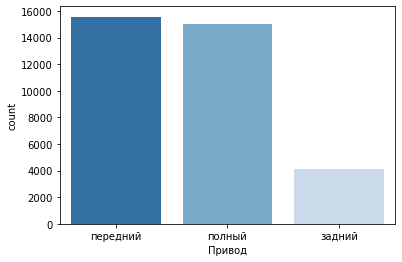

In [126]:
sns.countplot(x = "Привод", data = testcc, palette = "Blues_r")

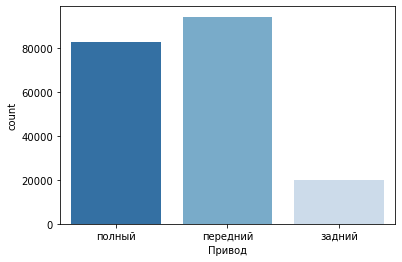

In [127]:
sns.countplot(x = "Привод", data = train, palette = "Blues_r")

### **price**

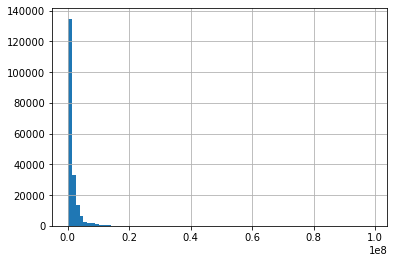

In [128]:
traincc['price'].hist(bins=77)

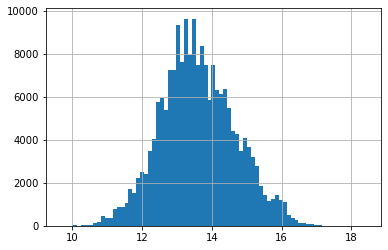

In [129]:
traincc['log_price'].hist(bins=77)

### Drop columns

In [69]:
columns_drop1 = ['model_info', 'name', 'car_url', 'sell_id', 'complectation_dict', 'equipment_dict',
                'vehicleConfiguration','Владение', 'image', 'parsing_unixtime', 'super_gen',
                'description',  'log_power']
columns_drop2 = ['model_info', 'name', 'sell_id', 'complectation_dict', 'equipment_dict',
                'vehicleConfiguration','Владение', 'image', 'super_gen','description',  'log_power',
                 'mileageNAN','hidden', 'price_EUR', 'price_USD','Комплектация','model','start_date']

In [70]:
testcc.drop(columns_drop1, axis=1, inplace=True)
traincc.drop(columns_drop2, axis=1, inplace=True)

In [71]:
traincc['model_name'] = traincc['model_name'].fillna(traincc['model_name'].describe().top)
traincc['Владельцы'] = traincc['Владельцы'].fillna(traincc['Владельцы'].describe().top)

In [133]:
traincc.describe()

,modelDate,numberOfDoors,productionDate,engineDisplacement,enginePower,mileage,price,leather,carter,ABS,...,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,log_price,bT_length,brand_length,Nalog_base,Nalog,years_old
count,196665.000000,196665.000000,196665.000000,196665.000000,196665.000000,196665.000000,1.966650e+05,196665.000000,196665.000000,196665.000000,...,196665.000000,196665.000000,196665.000000,196665.000000,196665.000000,196665.000000,196665.000000,196665.000000,196665.000000,196665.000000
mean,2008.702026,4.518003,2010.935871,14.015820,178.837500,140071.122676,1.453994e+06,0.162006,0.041904,0.183225,...,0.117428,0.054026,0.001708,0.028439,13.602085,11.209854,7.595734,54.241609,12955.995302,10.064129
std,7.515578,0.653853,7.111146,64.905772,86.239581,98593.029370,2.101454e+06,0.368458,0.200370,0.386852,...,0.321931,0.226069,0.041299,0.166224,1.067077,5.491664,2.673367,54.514696,16911.543762,7.111146
min,1904.000000,0.000000,1904.000000,0.800000,11.000000,100.000000,1.600000e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.680344,4.000000,3.000000,12.000000,456.000000,1.000000
25%,2005.000000,4.000000,2007.000000,1.600000,120.000000,56666.000000,3.950000e+05,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,12.886641,5.000000,5.000000,25.000000,3000.000000,5.000000
50%,2010.000000,5.000000,2012.000000,2.000000,150.000000,129000.000000,7.500000e+05,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,13.527828,13.000000,8.000000,35.000000,5250.000000,9.000000
75%,2014.000000,5.000000,2016.000000,2.500000,218.000000,196000.000000,1.654990e+06,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,14.319306,17.000000,10.000000,65.000000,14170.000000,14.000000
max,2020.000000,5.000000,2020.000000,520.000000,800.000000,1000000.000000,9.900000e+07,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,18.410630,23.000000,10.000000,5000.000000,160000.000000,117.000000


In [134]:
testcc.describe()

,enginePower,mileage,modelDate,numberOfDoors,productionDate,leather,carter,ABS,airbags,immob,...,from_salon,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,bT_length,brand_length,Nalog_base,Nalog,years_old
count,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,...,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000,34686.000000
mean,188.194142,162012.941360,2007.074728,4.450816,2009.264602,0.153635,0.013983,0.112524,0.075881,0.046272,...,0.045897,0.053912,0.042005,0.001845,0.016058,10.655625,6.364441,59.171135,14557.270772,11.735398
std,89.087035,100671.468542,7.415894,0.703040,7.047661,0.360604,0.117420,0.316014,0.264811,0.210077,...,0.209266,0.225848,0.200604,0.042916,0.125702,5.543661,2.350798,57.081272,17809.774780,7.047661
min,30.000000,100.000000,1904.000000,0.000000,1904.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,3.000000,12.000000,456.000000,1.000000
25%,125.000000,91153.500000,2004.000000,4.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,25.000000,3125.000000,7.000000
50%,169.000000,149779.500000,2008.000000,5.000000,2011.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,6.000000,45.000000,7605.000000,10.000000
75%,233.000000,215000.000000,2012.000000,5.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,8.000000,75.000000,17550.000000,15.000000
max,639.000000,1000000.000000,2020.000000,5.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,23.000000,10.000000,5000.000000,160000.000000,117.000000


In [72]:
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'bT_length', 'Nalog_base',
       'brand_length', 'Nalog', 'years_old', 'log_price']

In [73]:
correlation = traincc[num_cols].corr()
correlation

,engineDisplacement,enginePower,mileage,bT_length,Nalog_base,brand_length,Nalog,years_old,log_price
engineDisplacement,1.000000,0.148985,-0.041928,-0.047293,0.115049,-0.079169,0.131753,-0.047357,0.146826
enginePower,0.148985,1.000000,-0.159357,0.184949,0.692481,-0.315387,0.953934,-0.197514,0.601898
mileage,-0.041928,-0.159357,1.000000,-0.175326,-0.083630,-0.026556,-0.121274,0.727474,-0.628831
bT_length,-0.047293,0.184949,-0.175326,1.000000,0.134259,0.040776,0.156143,-0.198110,0.299142
Nalog_base,0.115049,0.692481,-0.083630,0.134259,1.000000,-0.233066,0.752939,-0.060675,0.395302
brand_length,-0.079169,-0.315387,-0.026556,0.040776,-0.233066,1.000000,-0.255352,0.002356,-0.254858
Nalog,0.131753,0.953934,-0.121274,0.156143,0.752939,-0.255352,1.000000,-0.129520,0.493030
years_old,-0.047357,-0.197514,0.727474,-0.198110,-0.060675,0.002356,-0.129520,1.000000,-0.738937
log_price,0.146826,0.601898,-0.628831,0.299142,0.395302,-0.254858,0.493030,-0.738937,1.000000


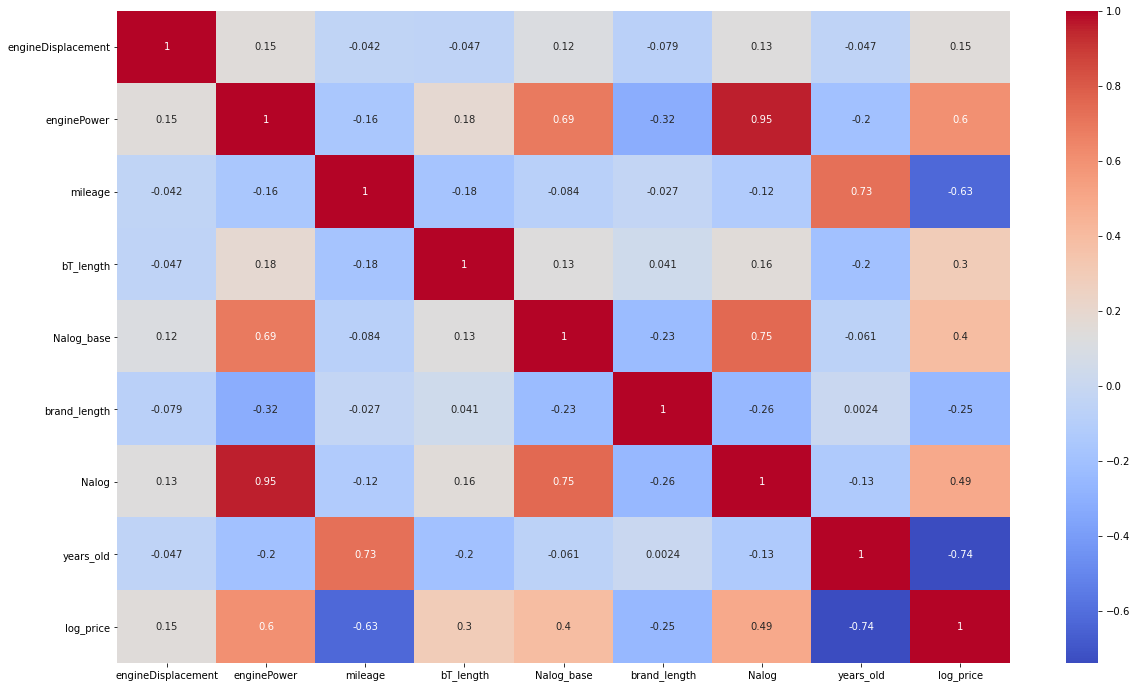

In [137]:
plt.figure(figsize=(20, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [74]:
columns_d = ['brand_length','description_word']
traincc.drop(columns_d, axis=1, inplace=True)
testcc.drop(columns_d, axis=1, inplace=True)

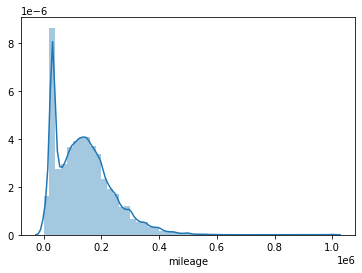

In [139]:
sns.distplot(traincc['mileage'])

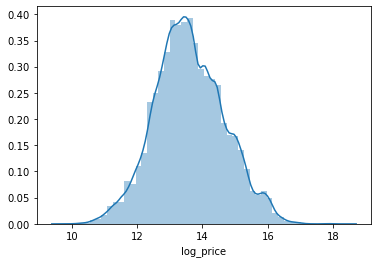

In [140]:
sns.distplot(traincc['log_price'])

In [141]:
testcc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   bodyType                  34686 non-null  object  
 1   brand                     34686 non-null  object  
 2   color                     34686 non-null  object  
 3   engineDisplacement        34686 non-null  object  
 4   enginePower               34686 non-null  float64 
 5   fuelType                  34686 non-null  object  
 6   mileage                   34686 non-null  int64   
 7   modelDate                 34686 non-null  int64   
 8   model_name                34686 non-null  object  
 9   numberOfDoors             34686 non-null  int64   
 10  productionDate            34686 non-null  int64   
 11  vehicleTransmission       34686 non-null  object  
 12  vendor                    34686 non-null  object  
 13  Владельцы                 34686 non-null  cate

### Concatenation train and test 

In [75]:
columns = list(testcc.columns) 

In [76]:
columns.remove('Nalog_base')

In [77]:
columns

['bodyType',
 'brand',
 'color',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'modelDate',
 'model_name',
 'numberOfDoors',
 'productionDate',
 'vehicleTransmission',
 'vendor',
 'Владельцы',
 'ПТС',
 'Привод',
 'Руль',
 'leather',
 'carter',
 'ABS',
 'airbags',
 'immob',
 'central_locking',
 'on_board_computer',
 'cruise_control',
 'climat_control',
 'multi_rudder',
 'power_steering',
 'light_and_rain_sensors',
 'сarbon_body_kits',
 'rear_diffuser_rkp',
 'door_closers',
 'rear_view_camera',
 'amg',
 'bi_xenon_headlights',
 'from_salon',
 'alloy_wheels',
 'parking_sensors',
 'dents',
 'roof_with_panoramic_view',
 'bT_length',
 'Nalog',
 'years_old',
 'age_intervals']

In [78]:
df_train = traincc[columns]
df_test = testcc[columns]

In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196665 entries, 0 to 35270
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   bodyType                  196665 non-null  object  
 1   brand                     196665 non-null  object  
 2   color                     196665 non-null  object  
 3   engineDisplacement        196665 non-null  float64 
 4   enginePower               196665 non-null  int64   
 5   fuelType                  196665 non-null  object  
 6   mileage                   196665 non-null  int64   
 7   modelDate                 196665 non-null  int64   
 8   model_name                196665 non-null  object  
 9   numberOfDoors             196665 non-null  int64   
 10  productionDate            196665 non-null  int64   
 11  vehicleTransmission       196665 non-null  object  
 12  vendor                    196665 non-null  object  
 13  Владельцы                 1966

In [147]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   bodyType                  34686 non-null  object  
 1   brand                     34686 non-null  object  
 2   color                     34686 non-null  object  
 3   engineDisplacement        34686 non-null  object  
 4   enginePower               34686 non-null  float64 
 5   fuelType                  34686 non-null  object  
 6   mileage                   34686 non-null  int64   
 7   modelDate                 34686 non-null  int64   
 8   model_name                34686 non-null  object  
 9   numberOfDoors             34686 non-null  int64   
 10  productionDate            34686 non-null  int64   
 11  vehicleTransmission       34686 non-null  object  
 12  vendor                    34686 non-null  object  
 13  Владельцы                 34686 non-null  cate

In [79]:
# y.to_csv('yy2201.csv', encoding = 'utf-8')
y = traincc['price']

In [150]:
y

0        200000.0
1         60000.0
2         99000.0
3         65000.0
4        100000.0
           ...   
35266    280000.0
35267    230000.0
35268    150000.0
35269    170000.0
35270    750000.0
Name: price, Length: 196665, dtype: float64

# Datasets

In [80]:
df_train['sample'] = 1 # трейн
df_test['sample'] = 0 # тест

<ipython-input-80-10a52cb7597b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['sample'] = 1 # трейн


In [81]:
#Concat
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [82]:
data.isna().sum()

bodyType                    0
brand                       0
color                       0
engineDisplacement          0
enginePower                 0
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
numberOfDoors               0
productionDate              0
vehicleTransmission         0
vendor                      0
Владельцы                   0
ПТС                         0
Привод                      0
Руль                        0
leather                     0
carter                      0
ABS                         0
airbags                     0
immob                       0
central_locking             0
on_board_computer           0
cruise_control              0
climat_control              0
multi_rudder                0
power_steering              0
light_and_rain_sensors      0
сarbon_body_kits            0
rear_diffuser_rkp           0
door_closers                0
rear_view_camera            0
amg       

In [83]:
data.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,from_salon,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,bT_length,Nalog,years_old,age_intervals,sample
0,лифтбек,SKODA,синий,1.2,105.0,бензин,74000,2013,OCTAVIA,5,...,0,0,0,0,0,7,2625.0,7,7,0
1,лифтбек,SKODA,чёрный,1.6,110.0,бензин,60563,2017,OCTAVIA,5,...,0,1,0,0,0,7,2750.0,4,7,0
2,лифтбек,SKODA,серый,1.8,152.0,бензин,88000,2013,SUPERB,5,...,0,0,0,0,0,7,6840.0,7,7,0
3,лифтбек,SKODA,коричневый,1.6,110.0,бензин,95000,2013,OCTAVIA,5,...,0,0,0,0,0,7,2750.0,7,7,0
4,лифтбек,SKODA,белый,1.8,152.0,бензин,58536,2008,OCTAVIA,5,...,0,1,0,0,0,7,6840.0,9,14,0


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231351 entries, 0 to 231350
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   bodyType                  231351 non-null  object  
 1   brand                     231351 non-null  object  
 2   color                     231351 non-null  object  
 3   engineDisplacement        231351 non-null  object  
 4   enginePower               231351 non-null  float64 
 5   fuelType                  231351 non-null  object  
 6   mileage                   231351 non-null  int64   
 7   modelDate                 231351 non-null  int64   
 8   model_name                231351 non-null  object  
 9   numberOfDoors             231351 non-null  int64   
 10  productionDate            231351 non-null  int64   
 11  vehicleTransmission       231351 non-null  object  
 12  vendor                    231351 non-null  object  
 13  Владельцы                 231

# ML

In [116]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state = RANDOM_SEED)

# Naive model

In [114]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))
#Эта модель будет предсказывать медианную цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.
tmp_train = X_train.copy()
tmp_train['price'] = y_train.values
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 98.95%


# Catboost

### Так как catboost умеет самостоятельно обрабатывать кат признаки, используем в первую очередь эту модель. 

In [117]:
#Определим cat_features ids для модели catboost
num_cols = ['modelDate', 
 'numberOfDoors',
 'productionDate',
 'engineDisplacement',
 'enginePower',
 'mileage',
 'Владельцы',
 'bT_length',
 'Nalog',
 'years_old','sample']
forcat = data.drop(num_cols,axis = 1)
cat_names = forcat.columns
cat_ids = [data.columns.get_loc(c) for c in cat_names if c in data]

In [120]:
model = CatBoostRegressor(iterations = 5000,
                          #learning_rate = 0.2,
                          bootstrap_type = 'Bernoulli',
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          #task_type = 'GPU',
                          #custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=cat_ids,
         eval_set=(X_test, y_test),
         verbose_eval=1000,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.043977
0:	learn: 2.2587975	test: 2.2314991	best: 2.2314991 (0)	total: 349ms	remaining: 29m 4s
1000:	learn: 0.1877040	test: 0.1867377	best: 0.1867377 (1000)	total: 3m 11s	remaining: 12m 45s
2000:	learn: 0.1679893	test: 0.1681506	best: 0.1681506 (2000)	total: 6m 33s	remaining: 9m 50s
3000:	learn: 0.1584434	test: 0.1596294	best: 0.1596294 (3000)	total: 9m 54s	remaining: 6m 35s
4000:	learn: 0.1527611	test: 0.1547596	best: 0.1547596 (4000)	total: 13m 14s	remaining: 3m 18s
4999:	learn: 0.1483175	test: 0.1508352	best: 0.1508320 (4997)	total: 16m 50s	remaining: 0us

bestTest = 0.1508320428
bestIteration = 4997

Shrink model to first 4998 iterations.


In [122]:
predict = model.predict(X_test)
# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 15.08%


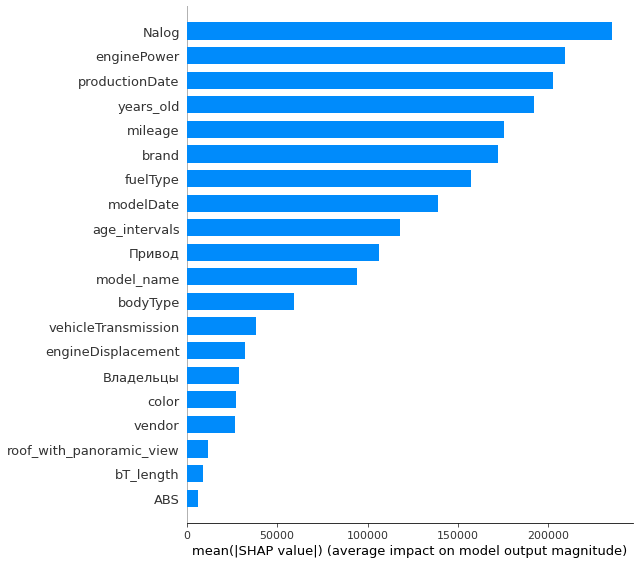

In [124]:
#Оценим вклад фичей в модель
import shap

# load JS visualization code to notebook
shap.initjs()
#explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

### Как видим некоторые созданные признаки, имеют значительное влияние на модель

# Log-target

In [ ]:
model = CatBoostRegressor(iterations = 25000,
                          #learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          #custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, np.log(y_train),
         cat_features=cat_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=5000,
         use_best_model=True,
         #plot=True
         )

predict = np.exp(model.predict(X_test))
# оцениваем точность
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")
#Модель была запущена на отдельном ноутбуке
#https://nbviewer.jupyter.org/github/rinatomarov/Car-price-prediction-Teamwork/blob/master/models/catboost-test.ipynb
#Mape on test : 11.51%
#Kaggle score: 12.47

## Label encoding

In [125]:
for column in ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vendor', 'Владельцы', 'vehicleTransmission', 'Привод', 'age_intervals']:
    data[column] = data[column].astype('category').cat.codes

In [126]:
bin_cols = ['ПТС', 'Руль']
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
data.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,from_salon,alloy_wheels,parking_sensors,dents,roof_with_panoramic_view,bT_length,Nalog,years_old,age_intervals,sample
0,9,8,14,1.2,105.0,0,74000,2013,713,5,...,0,0,0,0,0,7,2625.0,7,1,0
1,9,8,16,1.6,110.0,0,60563,2017,713,5,...,0,1,0,0,0,7,2750.0,4,1,0
2,9,8,13,1.8,152.0,0,88000,2013,957,5,...,0,0,0,0,0,7,6840.0,7,1,0
3,9,8,7,1.6,110.0,0,95000,2013,713,5,...,0,0,0,0,0,7,2750.0,7,1,0
4,9,8,1,1.8,152.0,0,58536,2008,713,5,...,0,1,0,0,0,7,6840.0,9,2,0


In [128]:
data['engineDisplacement'] = data['engineDisplacement'].astype('float')

In [158]:
# data.to_csv('data2201.csv')

In [159]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

### Второй ноутбук под названием "final_models" содержит модели с log-ами ,включая xbg-model ,которая выдала наилучший kaggle score - **8.02996** А также stacking

https://nbviewer.jupyter.org/github/rinatomarov/Car-price-prediction-Teamwork/blob/master/final_models.ipynb

# XGBOOST

In [ ]:
import xgboost as xgb

In [ ]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate= 0.01 ,max_depth=25, alpha=1,
                          n_estimators=15000,tree_method='gpu_hist')


In [ ]:
xg_reg.fit(X_train, np.log(y_train))

In [ ]:
predict_test = np.exp(xg_reg.predict(X_test)) 
predict_submission = np.exp(xg_reg.predict(X_sub))


In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_xg22.csv', index=False)


Результат XGBoost = 8.02996

# GradientBoosting

In [ ]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.01, max_depth=24, n_estimators=5000)
gb.fit(X_train, np.log(y_train))

In [ ]:
predict_test = np.exp(gb.predict(X_test))
predict_submission = np.exp(gb.predict(X_sub))

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_2201gb.csv', index=False)


Result GradientBoostingRegressor = 10.13381

# StackingRegressor

Result on Kaggle = 10.63027

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb

In [ ]:
estimators = [
    ('xg_reg', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate= 0.01 ,max_depth=22, alpha=1,
                          n_estimators=5000,tree_method='gpu_hist')),
    ('gb', GradientBoostingRegressor(min_samples_split=2, learning_rate=0.01, max_depth=15,
                                     n_estimators=5000))
]

In [ ]:
reg5 = StackingRegressor(estimators=estimators)
reg5.fit(X_train, np.log(y_train))


In [ ]:
predict_test = np.exp(reg5.predict(X_test))
predict_submission = np.exp(reg5.predict(X_sub))


In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission_1029st.csv', index=False)
            

## Another Stacking Model

**stacking.ipynb**
Модель с логами: https://github.com/rinatomarov/Car-price-prediction-Teamwork/tree/master/models 
### *MAPE: 12.47%*

In [130]:
X_pred = X_sub.values
X = X.values
y = y.values

In [131]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def compute_metric(regr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    return np.round(mape(y_test, y_test_pred)*100, 3)

def compute_meta_feature2(regr, X_train, X_test, y_train, cv, X_pred):    
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)
    
    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)
    
    X_meta_test = meta_regr.predict(X_test)
    X_meta_pred = meta_regr.predict(X_pred)
    
    return X_meta_train, X_meta_test, X_meta_pred

In [132]:
def generate_meta_features2(regr_s, X_train, X_test, y_train, cv, X_pred):
   
    features = [compute_meta_feature2(regr, X_train, X_test, y_train, cv, X_pred) for regr in tqdm(regr_s)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test, features_pred in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test, features_pred in features]).T
    stacked_features_pred = np.vstack([features_pred for features_train, features_test, features_pred in features]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from tqdm.notebook import tqdm
from sklearn.base import clone

stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features2([
    RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                          max_features='sqrt',max_depth=77, bootstrap=True, random_state=42),
    AdaBoostRegressor(random_state=42),
    ExtraTreesRegressor(random_state=42),
    RandomForestRegressor(random_state=42)], X_train, X_test, y_train, cv, X_pred)

regr = RandomForestRegressor(
 n_estimators=300,
 min_samples_split=2,
 min_samples_leaf=1,
 max_features='sqrt',
 max_depth=77,
 bootstrap=True, 
 random_state=42)

print(f'Stacking MAPE = {compute_metric(regr, X_train=stacked_features_train, y_train=y_train, X_test=stacked_features_test, y_test=y_test)}%')

# Conclusion

### С учетом проделанной работы ,проведенного парсинга, EDA, feature engineering и протестированных различных моделей , сделан следующий вывод:

### XGBRegressor отмечен ,как лучшая модель с наименьшим значением MAPE.
### Для учучшения модели можно также:
### Учесть колебания курса ,которые могут влиять на цену
### Спарсить еще больше данных, но на их обработку также уйдет больше времени
### Можно было бы кластеризовать автомобили по маркам и моделям и удалить выборсы на определенном расстоянии от центра масс. Таким образом можно было бы отсечь некоторые мошеннические объявления и опечатки